##### Noisy Quantum SVM - Spambase - Small Sample

In [1]:
# Check Qiskit, Qiskit Aer versions, Qiskit Machine Learning - Versions
import qiskit
import qiskit_aer
print(qiskit.__version__)
print("Aer:", qiskit_aer.__version__)

1.4.4
Aer: 0.17.2


In [2]:
# To ensure reproducibility of results
from qiskit_machine_learning.utils import algorithm_globals
algorithm_globals.random_seed = 12345

In [3]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [4]:
# --- Qiskit Imports ---
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

In [5]:
# --- Import Spambase Column Names ---
spambase_columns = [
    "word_freq_make",
    "word_freq_address",
    "word_freq_all",
    "word_freq_3d",
    "word_freq_our",
    "word_freq_over",
    "word_freq_remove",
    "word_freq_internet",
    "word_freq_order",
    "word_freq_mail",
    "word_freq_receive",
    "word_freq_will",
    "word_freq_people",
    "word_freq_report",
    "word_freq_addresses",
    "word_freq_free",
    "word_freq_business",
    "word_freq_email",
    "word_freq_you",
    "word_freq_credit",
    "word_freq_your",
    "word_freq_font",
    "word_freq_000",
    "word_freq_money",
    "word_freq_hp",
    "word_freq_hpl",
    "word_freq_george",
    "word_freq_650",
    "word_freq_lab",
    "word_freq_labs",
    "word_freq_telnet",
    "word_freq_857",
    "word_freq_data",
    "word_freq_415",
    "word_freq_85",
    "word_freq_technology",
    "word_freq_1999",
    "word_freq_parts",
    "word_freq_pm",
    "word_freq_direct",
    "word_freq_cs",
    "word_freq_meeting",
    "word_freq_original",
    "word_freq_project",
    "word_freq_re",
    "word_freq_edu",
    "word_freq_table",
    "word_freq_conference",
    "char_freq_;",
    "char_freq_(",
    "char_freq_[",
    "char_freq_!",
    "char_freq_$",
    "char_freq_#",
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total",
    # finally the target label column:
    "label"
]

# --- 1. Load the Spambase Dataset ---
file_path = r'C:\Users\User\Documents\MyProjects\FYP_ResearchProject\data\spambase\spambase.data'
df = pd.read_csv(file_path, header=None, names=spambase_columns)
df.drop_duplicates(inplace=True)


In [6]:
# 2. Some basic processing
print(f"Original shape of Spambase data: {df.shape}") # Prints original dataset shape
df.drop_duplicates(inplace=True) # Remove duplicates
print(f"Shape after dropping duplicates: {df.shape}\n") # Then print again the new shape

Original shape of Spambase data: (4210, 58)
Shape after dropping duplicates: (4210, 58)



In [7]:
sample_fraction = 0.2                     

X = df.drop('label', axis=1)
y = df['label']

X_sample, _, y_sample, _ = train_test_split(
    X, y,
    test_size=(1 - sample_fraction),
    stratify=y,
    random_state=42
)

print(f"Using stratified subsample of {len(X_sample)} instances "
      f"({sample_fraction*100:.0f}% of original)\n")


# Data Split
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.30,
    random_state=42,
    stratify=y_sample
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing  set shape: {X_test.shape}\n")


Using stratified subsample of 842 instances (20% of original)

Training set shape: (589, 57)
Testing  set shape: (253, 57)



In [8]:
# Scaling and PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # use .transform not fit_transform

# Convert back to DataFrames to retain column names for the next step
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

In [9]:
# --- Feature Selection ---
print("--- Feature Selection ---")
THRESH = 0.9
# Calculate correlation matrix on the SCALED TRAINING data
corr_matrix_train = X_train_scaled_df.corr().abs()
# Get the upper triangle of the correlation matrix
upper_triangle = corr_matrix_train.where(np.triu(np.ones(corr_matrix_train.shape), k=1).astype(bool))

# Find features with correlation greater than the threshold
columns_to_drop = set()
for column in upper_triangle.columns:
    high_corr_partners = upper_triangle.index[upper_triangle[column] > THRESH].tolist()
    if high_corr_partners:
        for partner in high_corr_partners:
            # IMPORTANT: Check correlation with the TRAINING target variable
            corr_main_vs_target = y_train.corr(X_train_scaled_df[column])
            corr_partner_vs_target = y_train.corr(X_train_scaled_df[partner])
            
            print(f"Found pair: ('{column}', '{partner}') with correlation > {THRESH}")
            if abs(corr_main_vs_target) < abs(corr_partner_vs_target):
                columns_to_drop.add(column)
                print(f"-> Dropping '{column}' (weaker correlation with target)")
            else:
                columns_to_drop.add(partner)
                print(f"-> Dropping '{partner}' (weaker correlation with target)")

to_drop_final = sorted(list(columns_to_drop))
print(f"\nTotal features to drop ({len(to_drop_final)}): {to_drop_final}")

# Drop the identified columns from both training and test sets
X_train_selected = X_train_scaled_df.drop(columns=to_drop_final)
X_test_selected = X_test_scaled_df.drop(columns=to_drop_final)

print(f"\nOriginal number of features: {X_train.shape[1]}")
print(f"Number of features after selection: {X_train_selected.shape[1]}\n")

--- Feature Selection ---
Found pair: ('word_freq_415', 'word_freq_857') with correlation > 0.9
-> Dropping 'word_freq_857' (weaker correlation with target)

Total features to drop (1): ['word_freq_857']

Original number of features: 57
Number of features after selection: 56



c:\Users\User\anaconda3\envs\qsvm_conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\User\anaconda3\envs\qsvm_conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [10]:
# PCA
n_components = 4
pca = PCA(n_components=n_components, random_state=42)

# Fit on the selected training data and transform both sets
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

print(f"Shape after PCA (Train): {X_train_pca.shape}")
print(f"Shape after PCA (Test):  {X_test_pca.shape}")

Shape after PCA (Train): (589, 4)
Shape after PCA (Test):  (253, 4)


##### Noise Simulation Setup

In [11]:
# Noise Model implementation from (Depolarizing error and Readout Error)
print("--- Setting up Noise Model ---")
# Error rates (realistic, not too high)
p_gate_1q = 0.001   # 0.1% error for single-qubit gates (u1, u2, u3)
p_gate_2q = 0.01    # 1.0% error for two-qubit gates (cx)
p_readout = 0.02    # 2.0% chance of wrong measurement

# Build the noise model
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(p_gate_1q, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p_gate_2q, 2), ['cx'])

# Add readout error (0 -> 1 or 1 -> 0)
readout_error = ReadoutError([[1 - p_readout, p_readout], [p_readout, 1 - p_readout]])
noise_model.add_all_qubit_readout_error(readout_error, ['measure'])

--- Setting up Noise Model ---


In [12]:
noisy_backend = AerSimulator(
    noise_model=noise_model,
    seed_simulator=12345,
)

noise_sampler = AerSampler.from_backend(
    backend=noisy_backend,
    default_shots=8192,  # 8192 is good for QSVM; adjust if too slow
)

print("Noisy SamplerV2 ready for QSVM training!")

Noisy SamplerV2 ready for QSVM training!


In [13]:
# Transpilation pass manager
pm = generate_preset_pass_manager(optimization_level=1, backend=noisy_backend)
print ("Realistic noise model applied !")

Realistic noise model applied !


##### Quantum Kernel Implementation

In [14]:
# Feature map setup
feature_dim = n_components
fm = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')

# Fidelity with noisy sampler and transpilation
fidelity = ComputeUncompute(sampler=noise_sampler, pass_manager=pm)

# Noisy quantum kernel
quantum_kernel_noisy = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm)

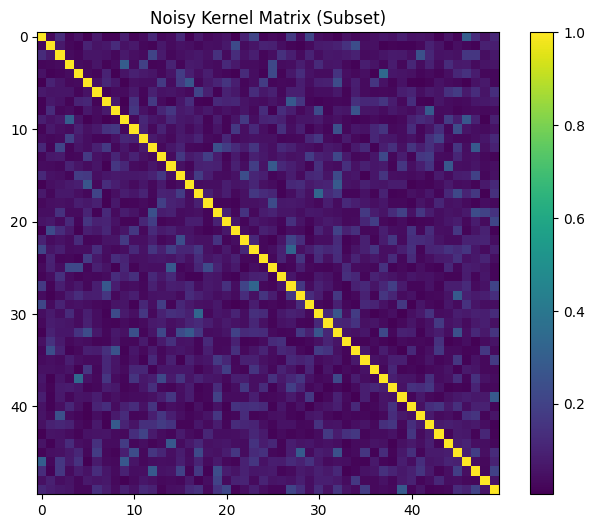

In [15]:
# Plot the ideal kernel matrix (on a subset if large)
matrix_train_noisy = quantum_kernel_noisy.evaluate(x_vec=X_train_pca[:50])  # Subset for plot if too large
plt.figure(figsize=(8, 6))
plt.imshow(matrix_train_noisy, cmap='viridis')
plt.title("Noisy Kernel Matrix (Subset)")
plt.colorbar()
plt.show()

In [16]:
# Ideal QSVC with tuned parameters
print("--- Training Ideal QSVC (Lung Cancer) ---")
start_time = time.time()

param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100],
    'class_weight': ['balanced']
}

# Use cross-validation suitable for small/imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# qsvc_ideal = QSVC(quantum_kernel=qkernel, C=1, class_weight='balanced')
# Grid search on QSVC
grid_search = GridSearchCV(
    QSVC(quantum_kernel=quantum_kernel_noisy),  # Your QSVC setup
    param_grid,
    cv=cv,
    scoring='accuracy',  # Or 'f1_macro' for imbalanced classes
    n_jobs=-1,
    verbose=1  # For progress output
)

grid_search.fit(X_train_pca, y_train)
qsvc_noisy = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
end_time = time.time()
print(f"QSVC training finished in {end_time - start_time:.2f} seconds.")


--- Training Ideal QSVC (Lung Cancer) ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits


Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\qsvm_conda\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\User\anaconda3\envs\qsvm_conda\Lib\site-packages\joblib\externals\loky\process_executor.py", line 635, in run
    self.flag_executor_shutting_down()
  File "c:\Users\User\anaconda3\envs\qsvm_conda\Lib\site-packages\joblib\externals\loky\process_executor.py", line 856, in flag_executor_shutting_down
    self.kill_workers(reason="executor shutting down")
  File "c:\Users\User\anaconda3\envs\qsvm_conda\Lib\site-packages\joblib\externals\loky\process_executor.py", line 866, in kill_workers
    kill_process_tree(p)
  File "c:\Users\User\anaconda3\envs\qsvm_conda\Lib\site-packages\joblib\externals\loky\backend\utils.py", line 19, in kill_process_tree
    _kill_process_tree_with_psutil(process)
  File "c:\Users\User\anaconda3\envs\qsvm_conda\Lib\site-packages\joblib\externals\loky\backend

OSError: [WinError 1450] Insufficient system resources exist to complete the requested service

##### Model Evaluation

In [ ]:
print("--- Test QSVC (Lung Cancer) ---")
start_time = time.time()

y_train_pred = qsvc_noisy.predict(X_train_pca)

end_time = time.time()
print(f"QSVC training finished in {end_time - start_time:.2f} seconds.")

print("--- Model Evaluation (Lung Cancer) ---")
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = qsvc_noisy.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)

generalization_gap = abs(train_accuracy - test_accuracy)

print(f"\n--- Noisy QSVM Evaluation (Spambase) ---")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")
print(f"Generalization Gap: {generalization_gap:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, zero_division=0))